In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras import models
from keras import optimizers

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_labels = train[labels].values

In [4]:
examples = pd.DataFrame(["I love you", "You suck", "You are idiot"])
examples.columns = ["comment_text"]

In [5]:
# Parameters
embed_size = 100
max_features = 20000
MAX_SEQUENCE_LENGTH = 100
EPOCH = 5
BATCH_SIZE = 32

In [6]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(train['comment_text']))
train_input = pad_sequences(tokenizer.texts_to_sequences(train['comment_text']), maxlen = MAX_SEQUENCE_LENGTH)
test_input = pad_sequences(tokenizer.texts_to_sequences(test['comment_text']), maxlen = MAX_SEQUENCE_LENGTH)
examples_input = pad_sequences(tokenizer.texts_to_sequences(examples['comment_text']), maxlen = MAX_SEQUENCE_LENGTH)

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HUAWEI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# Reference: https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python
from nltk.corpus import stopwords
EMBEDDING_FILE = '../data/glove.6B.100d.txt'
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype = 'float32')

def remove_stopwords(old_dict):
    for key in stopwords.words():
        if key in old_dict.keys():
            del old_dict[key]
    return old_dict
    
embedding_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE,encoding="utf8"))

all_embs = np.stack(embedding_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

word_index = tokenizer.word_index
word_index_without_sw = remove_stopwords(word_index)
num_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (num_words, embed_size))
i = 0
for word in word_index_without_sw.keys():
    if i >= num_words: 
        break
    if word in embedding_index.keys():
        embedding_matrix[i] = embedding_index[word]
    i += 1

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


In [9]:
model = models.Sequential()

model.add(layers.Input(shape = (MAX_SEQUENCE_LENGTH,)))
model.add(layers.Embedding(max_features, embed_size, weights=[embedding_matrix]))
model.add(layers.Bidirectional(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(50, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(6, activation="sigmoid"))

model.summary()

opt = optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer = opt, loss = "binary_crossentropy", metrics = ["accuracy"])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 100)          60400     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 2,065,756
Trainable params: 2,065,756
Non-trainable params: 0
______________________________________________

In [10]:
history = model.fit(train_input, train_labels, batch_size = BATCH_SIZE, epochs = EPOCH, validation_split = 0.2)

Epoch 1/5
3990/3990 [==============================] - 507s 127ms/step - loss: 0.0824 - accuracy: 0.9011 - val_loss: 0.0558 - val_accuracy: 0.9941
Epoch 2/5
3990/3990 [==============================] - 540s 135ms/step - loss: 0.0513 - accuracy: 0.9900 - val_loss: 0.0501 - val_accuracy: 0.9941
Epoch 3/5
3990/3990 [==============================] - 527s 132ms/step - loss: 0.0460 - accuracy: 0.9904 - val_loss: 0.0485 - val_accuracy: 0.9941
Epoch 4/5
3990/3990 [==============================] - 521s 131ms/step - loss: 0.0428 - accuracy: 0.9902 - val_loss: 0.0491 - val_accuracy: 0.9941
Epoch 5/5
3990/3990 [==============================] - 542s 136ms/step - loss: 0.0397 - accuracy: 0.9908 - val_loss: 0.0514 - val_accuracy: 0.9930


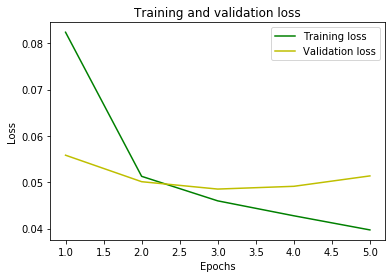

In [17]:
#Reference: https://towardsdatascience.com/machine-learning-recurrent-neural-networks-and-long-short-term-memory-lstm-python-keras-example-86001ceaaebc
import matplotlib.pyplot as plt
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

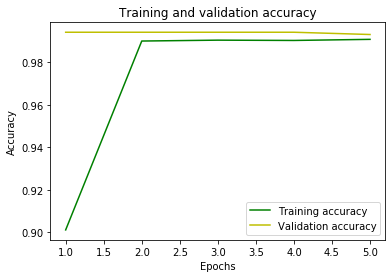

In [12]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
predict_on_test = model.predict(test_input)

In [14]:
out = pd.concat([test["id"], pd.DataFrame(predict_on_test)], axis=1, ignore_index = True)
output_columns = ['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
out.columns = output_columns
submission_file = open("../output/submission_LSTM.csv", "w")
out.to_csv('../output/submission_LSTM.csv', index = False)
submission_file.close()

In [15]:
out.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.998492,4.253148e-01,0.975650,5.949888e-02,9.284175e-01,0.277304
1,0000247867823ef7,0.000041,9.964679e-09,0.000006,7.399759e-08,8.653031e-07,0.000002
2,00013b17ad220c46,0.000674,6.121878e-07,0.000123,4.918619e-06,3.174121e-05,0.000042
3,00017563c3f7919a,0.000126,1.725480e-08,0.000015,1.184419e-07,4.273819e-06,0.000002
4,00017695ad8997eb,0.000138,4.265313e-08,0.000017,3.786655e-07,3.630112e-06,0.000006


In [16]:
predict_on_examples = model.predict(examples_input)
exmaples_out = pd.concat([examples["comment_text"], pd.DataFrame(predict_on_examples)], axis=1, ignore_index = True)
exmaples_out.columns = ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
exmaples_out

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,I love you,0.035164,0.000100,0.004437,0.000821,0.004373,0.001987
1,You suck,0.997844,0.270334,0.987066,0.006998,0.877760,0.050175
2,You are idiot,0.995527,0.052479,0.808529,0.005319,0.914491,0.043687
